<a href="https://colab.research.google.com/github/Mihirirj/Audio_PRE-FE/blob/main/lstm_cnn_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import pickle
import timeit
from tqdm import tqdm

# Audio Processing
import librosa
import librosa.display

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense,
    LSTM, Layer
)
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


try:
    from google.colab import drive
    print("Running in Google Colab. Installing dependencies.")
    !apt-get update -qq && apt-get install -y libsndfile1 -qq
except ImportError:
    print("Not running in Google Colab.  dependencies are installed.")

print("\nLibraries imported.")

Running in Google Colab. Installing dependencies.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

Libraries imported.


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    CREMA_D_PATH = "/content/drive/MyDrive/AudioWAV/"
except ImportError:

    CREMA_D_PATH = "./AudioWAV/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

crema_directory_list = os.listdir(CREMA_D_PATH)

file_emotion = []
file_path = []

for file in tqdm(crema_directory_list, desc="Processing filenames"):
    if file.endswith('.wav'):
        file_path.append(os.path.join(CREMA_D_PATH, file))
        part = file.split('_')

        if len(part) > 2:
            if part[2] == 'SAD':
                file_emotion.append('sad')
            elif part[2] == 'ANG':
                file_emotion.append('angry')
            elif part[2] == 'DIS':
                file_emotion.append('disgust')
            elif part[2] == 'FEA':
                file_emotion.append('fear')
            elif part[2] == 'HAP':
                file_emotion.append('happy')
            elif part[2] == 'NEU':
                file_emotion.append('neutral')
            else:
                file_emotion.append('Unknown')
        else:
            file_emotion.append('Unknown')


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)

data_path = data_path[data_path.Emotions != 'Unknown']

print("\nCREMA-D DataFrame created successfully.")
print("Emotion Counts:")
print(data_path['Emotions'].value_counts())

Processing filenames: 100%|██████████| 7442/7442 [00:00<00:00, 431162.52it/s]


CREMA-D DataFrame created successfully.
Emotion Counts:
Emotions
fear       1271
disgust    1271
sad        1271
happy      1271
angry      1271
neutral    1087
Name: count, dtype: int64


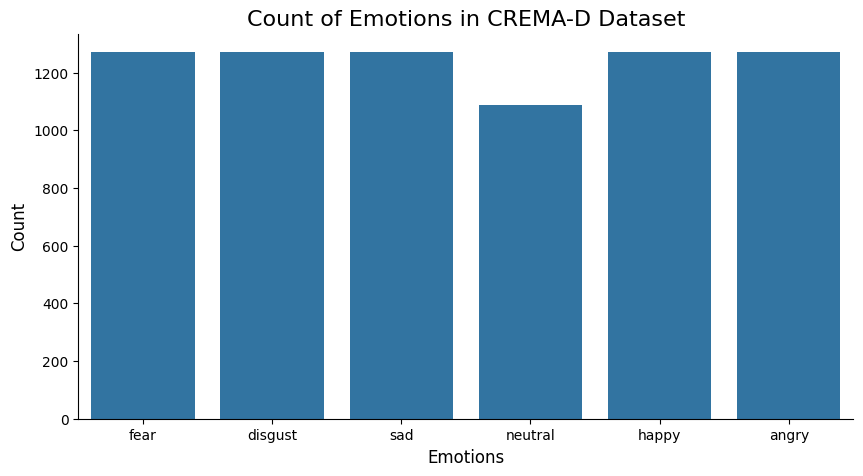

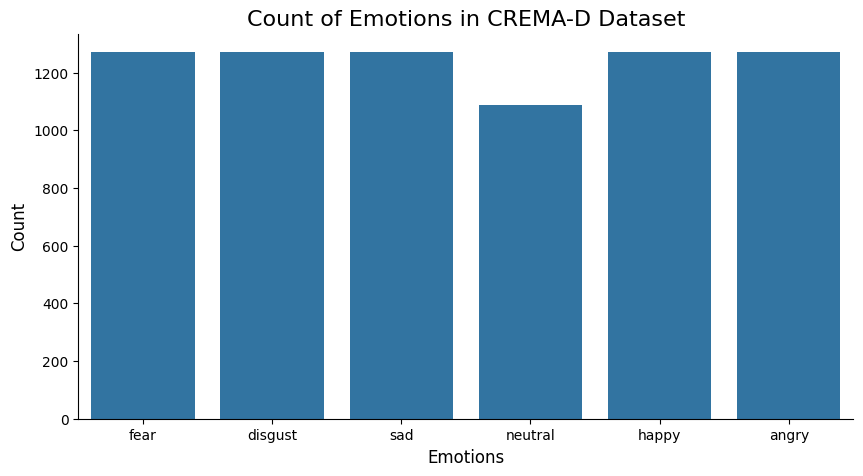

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Count of Emotions in CREMA-D Dataset', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show(_)

In [ ]:


def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def pitch(data, sampling_rate, pitch_factor=0.7):

    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def stretch(data, rate=0.8):

    return librosa.effects.time_stretch(y=data, rate=rate)

def extract_features_sequential(data, sr=22050, n_mfcc=40):

    mfccs = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

def get_features_with_augmentation_sequential(path):

    data, sr = librosa.load(path, duration=2.5, offset=0.6)

    # Original Features
    res1 = extract_features_sequential(data, sr)
    # Noise-Augmented Features
    noise_data = noise(data)
    res2 = extract_features_sequential(noise_data, sr)
    # Pitch-Augmented Features
    pitch_data = pitch(data, sr)
    res3 = extract_features_sequential(pitch_data, sr)
    # Stretch-Augmented Features
    stretch_data = stretch(data)
    res4 = extract_features_sequential(stretch_data, sr)

    return [res1, res2, res3, res4]


In [ ]:

start_time = timeit.default_timer()

X_seq, Y_seq = [], []
for path, emotion in tqdm(zip(data_path.Path, data_path.Emotions), total=len(data_path)):
    try:
        feature_list = get_features_with_augmentation_sequential(path)
        for features in feature_list:
            X_seq.append(features)
            Y_seq.append(emotion)
    except Exception as e:
        print(f"Error processing {path}: {e}")

# Find the maximum length of any sequence
max_len = max([len(x) for x in X_seq])
print(f"\nMaximum sequence length found: {max_len}")


X_padded = pad_sequences(X_seq, maxlen=max_len, padding='post', dtype='float32')

stop_time = timeit.default_timer()
print(f'Feature extraction and padding completed in: {stop_time - start_time:.2f}s')


np.save('X_padded_features.npy', X_padded)
np.save('Y_labels.npy', np.array(Y_seq))
with open('max_len.txt', 'w') as f:
    f.write(str(max_len))

print("\nSequential features and labels saved to '.npy' files.")
print("Max sequence length saved to 'max_len.txt'")

100%|██████████| 7442/7442 [17:59<00:00,  6.89it/s]



Maximum sequence length found: 135
Feature extraction and padding completed in: 1080.61s

Sequential features and labels saved to '.npy' files.
Max sequence length saved to 'max_len.txt'


In [ ]:
# Load the pre-processed data
X = np.load('X_padded_features.npy')
Y = np.load('Y_labels.npy')


encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

scaler = StandardScaler()
x_train_2d = x_train.reshape(x_train.shape[0], -1)
x_train_scaled_2d = scaler.fit_transform(x_train_2d)
x_train = x_train_scaled_2d.reshape(x_train.shape)

x_test_2d = x_test.reshape(x_test.shape[0], -1)
x_test_scaled_2d = scaler.transform(x_test_2d)
x_test = x_test_scaled_2d.reshape(x_test.shape)

print(f"\nData shapes after splitting and scaling:")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")


Data shapes after splitting and scaling:
x_train: (23814, 135, 40)
y_train: (23814, 6)
x_test: (5954, 135, 40)
y_test: (5954, 6)


In [ ]:
# Define a custom Attention layer
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1), initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1), initializer="zeros")
        super(Attention, self).build(input_shape)

    def call(self, x):
        et = K.squeeze(K.tanh(K.dot(x, self.W) + self.b), axis=-1)
        at = K.softmax(et)
        at = K.expand_dims(at, axis=-1)
        output = x * at
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(Attention, self).get_config()


input_shape = (x_train.shape[1], x_train.shape[2])

model = Sequential()

# CNN Layers
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides=2, padding='same'))

# LSTM Layer - return_sequences=True is required for the Attention layer
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Attention Layer
model.add(Attention())

# Dense Layers
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())

# Output Layer
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 135, 256)       │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 135, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 68, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 68, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 68, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 34, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 34, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 17, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 17, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 128)            │           145 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 349,719 (1.33 MB)

 Trainable params: 348,695 (1.33 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [20]:

early_stop = EarlyStopping(monitor='val_accuracy', mode='auto', patience=15, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1, factor=0.5, min_lr=0.00001)
model_checkpoint = ModelCheckpoint('best_cnn_lstm_attention_model.keras', monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=64,
    validation_data=(x_test, y_test),
    callbacks=[early_stop, lr_reduction, model_checkpoint]
)

print("\nModel training complete.")

Epoch 1/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 129s 324ms/step - accuracy: 0.4097 - loss: 1.4885 - val_accuracy: 0.5353 - val_loss: 1.1904 - learning_rate: 0.0010
Epoch 2/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 117s 314ms/step - accuracy: 0.5449 - loss: 1.1728 - val_accuracy: 0.5778 - val_loss: 1.1013 - learning_rate: 0.0010
Epoch 3/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 304ms/step - accuracy: 0.6083 - loss: 1.0234 - val_accuracy: 0.5722 - val_loss: 1.1078 - learning_rate: 0.0010
Epoch 4/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 321ms/step - accuracy: 0.6606 - loss: 0.8985 - val_accuracy: 0.6663 - val_loss: 0.8906 - learning_rate: 0.0010
Epoch 5/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 139s 314ms/step - accuracy: 0.7061 - loss: 0.7934 - val_accuracy: 0.6770 - val_loss: 0.8919 - learning_rate: 0.0010
Epoch 6/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 117s 314ms/step - accuracy: 0.7295 - loss: 0.7135 - val_accuracy: 0.6896 - val_loss: 0.8451 - learning_rate: 0.0010
Epoch 7/100
373/373 ━━━━━━━━━━━━━━━━━━━━ 138s 302ms/step -

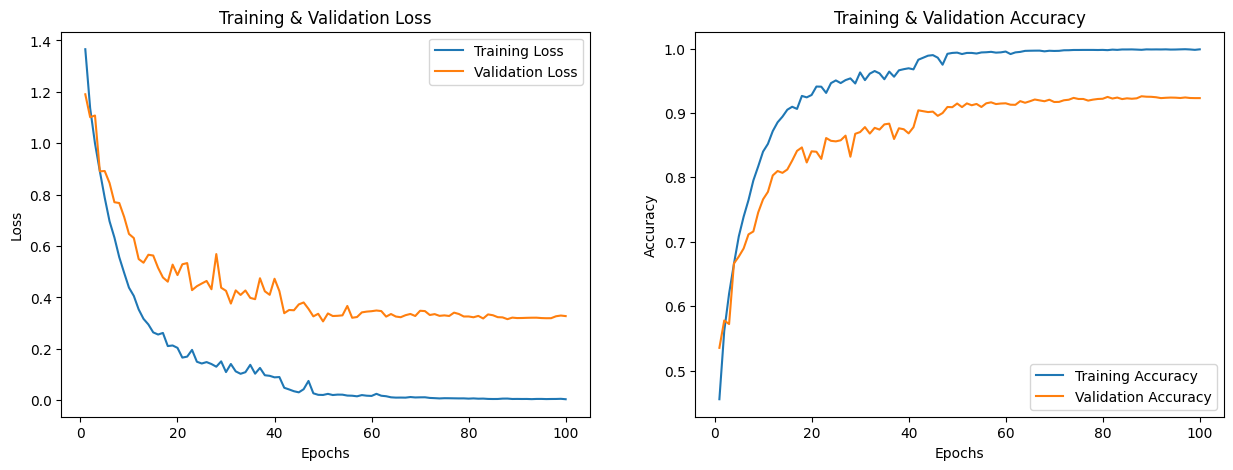


Final Model Evaluation on Test Data:
Test Accuracy: 92.59%
Test Loss: 0.3154
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step

Test set predictions saved to lstm_cnn_preds.npy

Classification Report:
              precision    recall  f1-score   support

       angry       0.98      0.94      0.96      1011
     disgust       0.94      0.92      0.93      1035
        fear       0.91      0.90      0.91      1016
       happy       0.95      0.92      0.94      1015
     neutral       0.89      0.93      0.91       837
         sad       0.88      0.94      0.91      1040

    accuracy                           0.93      5954
   macro avg       0.93      0.93      0.93      5954
weighted avg       0.93      0.93      0.93      5954



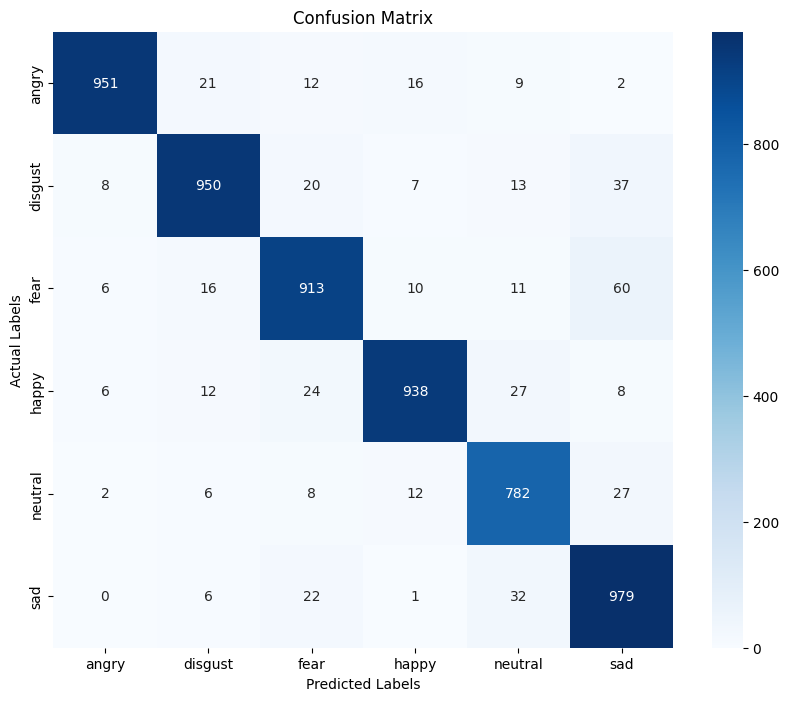

In [21]:

epochs = range(1, len(history.history['accuracy']) + 1)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(epochs, history.history['loss'], label='Training Loss')
ax[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
ax[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.show()


print("\nFinal Model Evaluation on Test Data:")
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


lstm_cnn_preds = model.predict(x_test)


np.save("lstm_cnn_preds.npy", lstm_cnn_preds)
print("\nTest set predictions saved to lstm_cnn_preds.npy")


y_pred_labels = encoder.inverse_transform(lstm_cnn_preds)
y_test_labels = encoder.inverse_transform(y_test)


print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=encoder.categories_[0]))


cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.categories_[0], yticklabels=encoder.categories_[0])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [22]:
def get_valence(emotion):

    emotion = emotion.lower()
    if emotion == 'happy':
        return 'Positive'
    elif emotion in ['sad', 'angry', 'fear', 'disgust']:
        return 'Negative'
    else:
        return 'Neutral'

print("\n--- Example Predictions with Emotional Valence ---")
for i in range(10):
    actual_emotion = y_test_labels[i][0]
    predicted_emotion = y_pred_labels[i][0]
    valence = get_valence(predicted_emotion)
    print(f"Actual: {actual_emotion:<10} | Predicted: {predicted_emotion:<10} | Valence: {valence}")


--- Example Predictions with Emotional Valence ---
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: angry      | Predicted: angry      | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative
Actual: disgust    | Predicted: disgust    | Valence: Negative
Actual: fear       | Predicted: fear       | Valence: Negative
Actual: neutral    | Predicted: neutral    | Valence: Neutral
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: happy      | Predicted: happy      | Valence: Positive
Actual: disgust    | Predicted: fear       | Valence: Negative
Actual: sad        | Predicted: sad        | Valence: Negative


In [23]:

model_json = model.to_json()
with open("cnn_lstm_attention_model.json", "w") as json_file:
    json_file.write(model_json)
print("Model architecture saved to cnn_lstm_attention_model.json")
print("Best model weights were saved to best_cnn_lstm_attention_model.keras during training.")


with open('scaler_seq.pickle', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler saved to scaler_seq.pickle")

with open('encoder_seq.pickle', 'wb') as f:
    pickle.dump(encoder, f)
print("Encoder saved to encoder_seq.pickle")

Model architecture saved to cnn_lstm_attention_model.json
Best model weights were saved to best_cnn_lstm_attention_model.keras during training.
Scaler saved to scaler_seq.pickle
Encoder saved to encoder_seq.pickle


In [24]:
def predict_emotion_and_valence(audio_path):
    """
    Loads a single audio file and predicts its emotion and valence using the
    saved model and preprocessing objects.
    """
    print(f"\n--- Prediction for: {os.path.basename(audio_path)} ---")
    try:

        with open('cnn_lstm_attention_model.json', 'r') as json_file:
            loaded_model_json = json_file.read()
        loaded_model = model_from_json(
            loaded_model_json,
            custom_objects={'Attention': Attention}
        )

        loaded_model.load_weights("best_cnn_lstm_attention_model.keras")


        with open('scaler_seq.pickle', 'rb') as f:
            scaler = pickle.load(f)
        with open('encoder_seq.pickle', 'rb') as f:
            encoder = pickle.load(f)
        with open('max_len.txt', 'r') as f:
            max_len = int(f.read())


        data, sr = librosa.load(audio_path, duration=2.5, offset=0.6)
        features = extract_features_sequential(data, sr, n_mfcc=40)

        padded_features = pad_sequences([features], maxlen=max_len, padding='post', dtype='float32')
        padded_features_2d = padded_features.reshape(1, -1)
        scaled_features_2d = scaler.transform(padded_features_2d)
        final_features = scaled_features_2d.reshape(padded_features.shape)

        # Make prediction
        prediction = loaded_model.predict(final_features, verbose=0)
        predicted_label = encoder.inverse_transform(prediction)[0][0]
        predicted_valence = get_valence(predicted_label)

        return predicted_label, predicted_valence

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None

try:
    # Select a random file from the dataset to test
    if not data_path.empty:
      test_file_path = data_path.Path.sample(1).iloc[0]
      predicted_emotion, predicted_valence = predict_emotion_and_valence(test_file_path)

      if predicted_emotion:
          print(f"\n--- Prediction Test Result ---")
          print(f"Predicted Emotion: {predicted_emotion.upper()}")
          print(f"Predicted Valence: {predicted_valence.upper()}")
except Exception as e:
    print(f"\nCould not run prediction example. Error: {e}")


--- Prediction for: 1043_WSI_HAP_XX.wav ---

--- Prediction Test Result ---
Predicted Emotion: HAPPY
Predicted Valence: POSITIVE


In [25]:
drive_save_path = "/content/drive/MyDrive/My_LSTM_CNN_ATTENTION_Speech_Model"

!mkdir -p "{drive_save_path}"

print(f"Ready to save files to: {drive_save_path}")

Ready to save files to: /content/drive/MyDrive/My_LSTM_CNN_ATTENTION_Speech_Model


In [26]:
source_file = "lstm_cnn_preds.npy"


destination_path = "/content/drive/MyDrive/My_LSTM_CNN_ATTENTION_Speech_Model/"


!cp "{source_file}" "{destination_path}"

print(f"Successfully copied '{source_file}' to your Google Drive!")

Successfully copied 'lstm_cnn_preds.npy' to your Google Drive!


In [27]:
!ls -lh "/content/drive/MyDrive/My_LSTM_CNN_ATTENTION_Speech_Model"

total 140K
-rw------- 1 root root 140K Aug  3 09:21 lstm_cnn_preds.npy
